In [123]:
# https://github.com/nyoki-mtl/pytorch-discriminative-loss
# https://github.com/gymoon10/Instance-Segmentation-with-Discriminative-Loss


import os
import random

import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from utils.dl.niab import IMG_TRANSFORMS, MASK_TRANSFORMS, InstanceDataset

Size of dataset: 8
Image shape: torch.Size([1, 256, 256])
Unique values in binary mask: tensor([0., 1.])
Unique values in instance mask: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


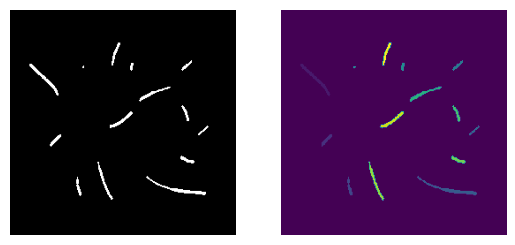

In [154]:
dummy_dataset = InstanceDataset(
    "../sample_data/dummy_instances/binary_masks",
    "../sample_data/dummy_instances/instance_masks",
    img_transform=IMG_TRANSFORMS,
    mask_transform=MASK_TRANSFORMS,
)

# Could change the dimention to be 512 (512/16=32 (given that 2^5=32 and resnet34 has 5 layers of downsampling by a factor of 2))

random_index = random.randint(0, len(dummy_dataset) - 1)
binary_mask, instance_mask = dummy_dataset[random_index]

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(
    binary_mask.permute(1, 2, 0), cmap="gray"
)  # permute to change the order of the channels so that it can be displayed correctly
plt.axis("off")

# Plot mask
plt.subplot(1, 2, 2)
plt.imshow(instance_mask.permute(1, 2, 0))
plt.axis("off")

print(f"Size of dataset: {len(dummy_dataset)}")
print(f"Image shape: {binary_mask.shape}")

# TODO: Be sure that the segmentation masks are binary and not RGB
# I am pretty sure at the moment that the masks are RGB as they are a jpeg image and not a png image - I need to convert them to greyscale
print(f"Unique values in binary mask: {torch.unique(binary_mask)}")
print(f"Unique values in instance mask: {torch.unique(instance_mask)}")

plt.show()

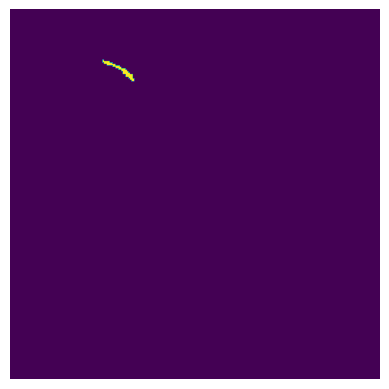

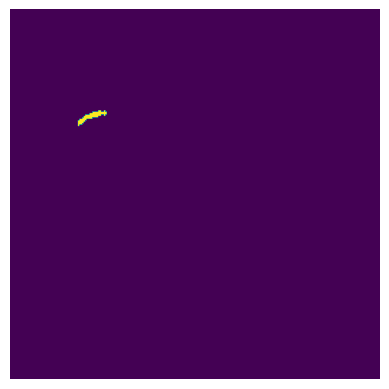

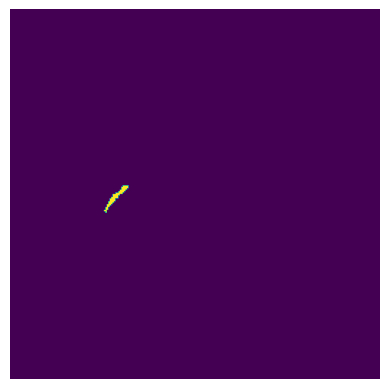

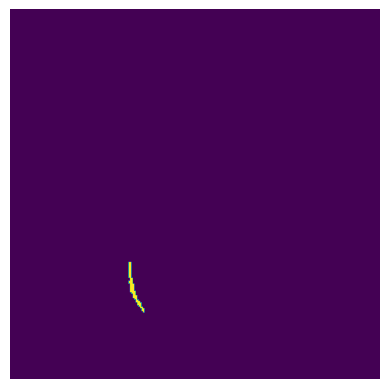

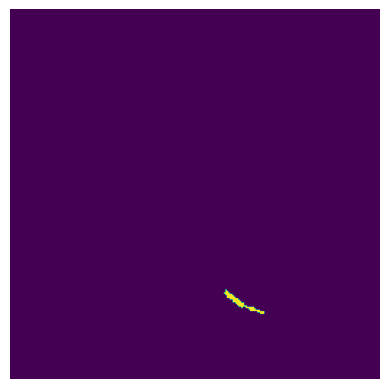

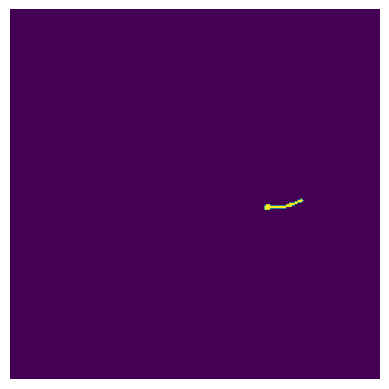

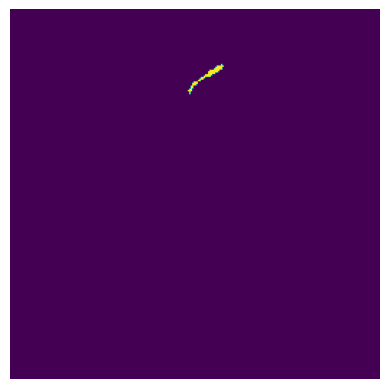

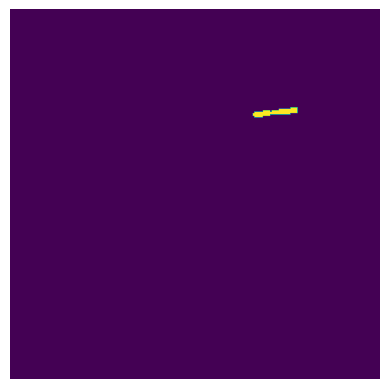

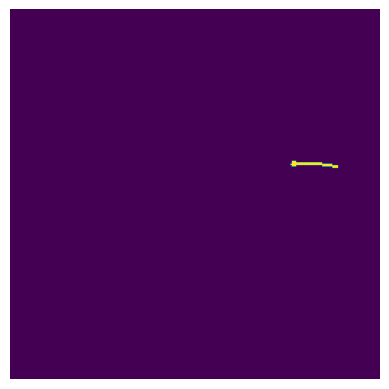

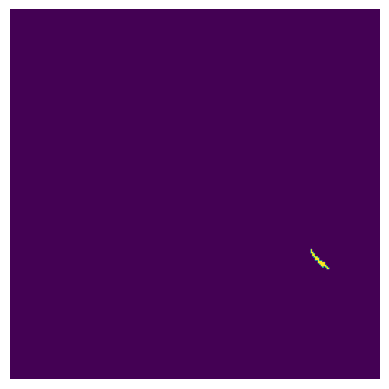

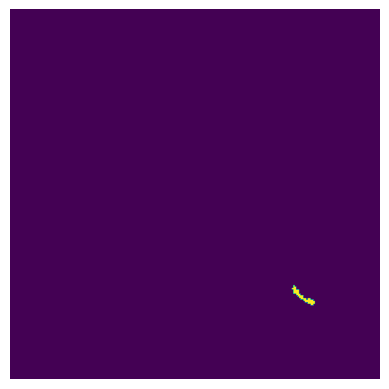

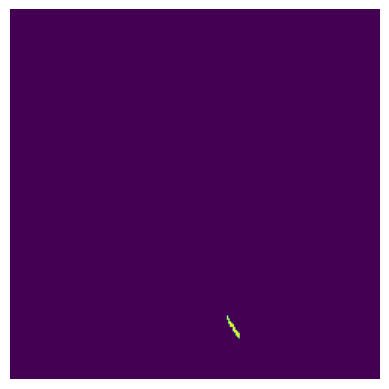

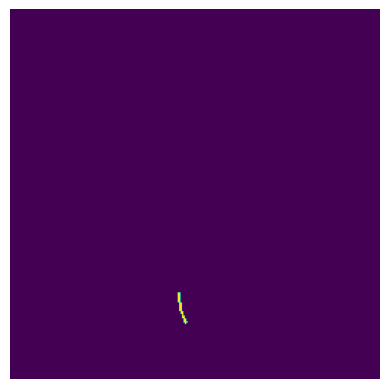

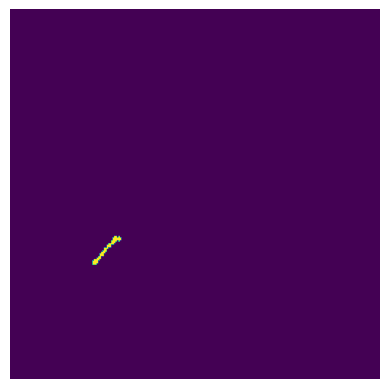

In [149]:
# display each instance individually
for i in range(1, int(torch.max(instance_mask)) + 1):
    plt.imshow(instance_mask[0] == i)
    plt.axis("off")
    plt.show()

In [155]:
# Split the dataset into training and validation sets
total_size = len(dummy_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
training_dataset, validation_dataset = random_split(
    dummy_dataset, [train_size, val_size]
)

# How much data?
print(f"Size of training dataset: {len(training_dataset)}")
print(f"Size of validation dataset: {len(validation_dataset)}")

# Post-transformation, what does the data look like?
print(f"Shape of first input entry (post-transformation): {dummy_dataset[0][0].shape}")
print(f"Shape of first label entry (post-transformation): {dummy_dataset[0][1].shape}")

Size of training dataset: 6
Size of validation dataset: 2
Shape of first input entry (post-transformation): torch.Size([1, 256, 256])
Shape of first label entry (post-transformation): torch.Size([1, 256, 256])


In [156]:
"""
This is the implementation of following paper:
https://arxiv.org/pdf/1802.05591.pdf
This implementation is based on following code:
https://github.com/Wizaron/instance-segmentation-pytorch
"""

import torch
import torch.nn as nn


class DiscriminativeLoss(nn.Module):
    def __init__(self, delta_v=0.5, delta_d=1.5, alpha=1.0, beta=1.0, gamma=0.001):
        super(DiscriminativeLoss, self).__init__()
        self.delta_v = delta_v
        self.delta_d = delta_d
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, embeddings, instance_ids, binary_mask):
        batch_size, embed_dim, height, width = embeddings.size()
        var_loss = 0.0
        dist_loss = 0.0
        reg_loss = 0.0

        for b in range(batch_size):
            embedding = (
                embeddings[b].permute(1, 2, 0).view(-1, embed_dim)
            )  # Reshape to (H*W, D)
            instance_id = instance_ids[b].view(-1)  # Reshape to (H*W)
            # foreground_mask = binary_mask[b].view(-1).bool()  # Reshape and convert to boolean mask

            # # Filter embeddings and instance_ids to include only foreground pixels
            # embedding = embedding[foreground_mask]
            # instance_id = instance_id[foreground_mask]

            unique_ids = instance_id.unique()

            instance_means = []
            for uid in unique_ids:
                mask = instance_id == uid
                if mask.sum() == 0:
                    continue
                instance_embedding = embedding[mask]
                instance_mean = instance_embedding.mean(dim=0)
                instance_means.append(instance_mean)

                var_loss += torch.mean(
                    torch.relu(
                        torch.norm(instance_embedding - instance_mean, dim=1)
                        - self.delta_v
                    )
                    ** 2
                )

            instance_means = torch.stack(instance_means)
            if len(instance_means) > 1:
                for i in range(len(instance_means)):
                    for j in range(i + 1, len(instance_means)):
                        dist_loss += (
                            torch.relu(
                                2 * self.delta_d
                                - torch.norm(instance_means[i] - instance_means[j])
                            )
                            ** 2
                        )

            reg_loss += torch.mean(torch.norm(instance_means, dim=1))

        var_loss = var_loss / batch_size
        dist_loss = dist_loss / (batch_size * (len(unique_ids) - 1))
        reg_loss = reg_loss / batch_size

        loss = self.alpha * var_loss + self.beta * dist_loss + self.gamma * reg_loss
        return loss

In [157]:
BATCH_SIZE = 2**1  # should be divisible by the training dataset size
EPOCHS = 100

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Training/fitting using {device} device")

# Create a data loader to handle loading data in and out of memory in batches
train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Look at the shape of the data coming out of the data loader (batch size, channels, height, width)
for X, y in validation_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Create an instance of the model and move it to the device (GPU or CPU)
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=16,  # model output channels (number of classes in your dataset)
).to(device)


def fit(dataloader, model, loss_fn, optimizer, scheduler, device, log_freq=10) -> None:
    """
    Fit the model to the data using the loss function and optimizer
    Taken from the official PyTorch quickstart tutorial (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
    :param dataloader:
    :param model:
    :param loss_fn:
    :param optimizer:
    :param scheduler:
    :param device:
    :param log_freq:
    :return: None
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # move data to device (GPU or CPU), ensure that the data and model are on the same device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # forward pass
        loss = loss_fn(pred, y, X)  # Compute discriminative loss

        # Backpropagation
        loss.backward()  # backward pass (calculate gradients)
        optimizer.step()  # update params
        optimizer.zero_grad()  # reset gradients to zero

        # To avoid too much output, only print every n batches (log_freq), by default every 10 batches
        if batch % log_freq == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y, X).item()  # Compute discriminative loss

    # Calculate averages
    avg_loss = total_loss / num_batches

    print(f"Validation Metrics: Avg loss: {avg_loss:>8f}")
    return avg_loss


# loss_fn = smp.losses.SoftCrossEntropyLoss(
#     reduction="mean",
#     smooth_factor=0.1,
# )


loss_fn = DiscriminativeLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=3e-4
)  # high learning rate and allow it to decay

best_loss = float("inf")
for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    fit(train_dataloader, model, loss_fn, optimizer, None, device, log_freq=2)
    val_loss = validate(validation_dataloader, model, loss_fn)
    if val_loss < best_loss:
        best_loss = val_loss
print("Done!")

Training/fitting using cuda device
Shape of X: torch.Size([2, 1, 256, 256])
Shape of y: torch.Size([2, 1, 256, 256]) torch.int64
Epoch 1
-------------------------------
loss: 326.134705  [    2/    6]
loss: 112.724480  [    6/    6]
Validation Metrics: Avg loss: 24.892311
Epoch 2
-------------------------------
loss: 60.510048  [    2/    6]
loss: 49.906525  [    6/    6]
Validation Metrics: Avg loss: 91.223061
Epoch 3
-------------------------------
loss: 37.843704  [    2/    6]
loss: 35.822659  [    6/    6]
Validation Metrics: Avg loss: 64.827713
Epoch 4
-------------------------------
loss: 30.073519  [    2/    6]
loss: 28.146084  [    6/    6]
Validation Metrics: Avg loss: 36.281948
Epoch 5
-------------------------------
loss: 23.931387  [    2/    6]
loss: 22.880484  [    6/    6]
Validation Metrics: Avg loss: 38.864571
Epoch 6
-------------------------------
loss: 20.244425  [    2/    6]
loss: 19.433308  [    6/    6]
Validation Metrics: Avg loss: 53.624733
Epoch 7
---------

In [158]:
model.eval()
with torch.no_grad():
    embeddings = model(binary_mask.unsqueeze(0).to(device))

print(f"Shape of embeddings: {embeddings.shape}")

embeddings = embeddings.squeeze(0)  # Remove batch dimension, resulting shape (D, H, W)

Shape of embeddings: torch.Size([1, 16, 256, 256])


In [159]:
import numpy as np
from sklearn.cluster import KMeans

# Reshape embeddings to (H*W, D)
D, H, W = embeddings.shape
embeddings_flat = embeddings.permute(1, 2, 0).reshape(-1, D).cpu().numpy()

# Perform k-means clustering
num_instances = 16  # Adjust based on your data
kmeans = KMeans(n_clusters=num_instances, random_state=0).fit(embeddings_flat)
instance_labels_flat = kmeans.labels_

# Reshape labels to original image size
instance_labels = instance_labels_flat.reshape(H, W)

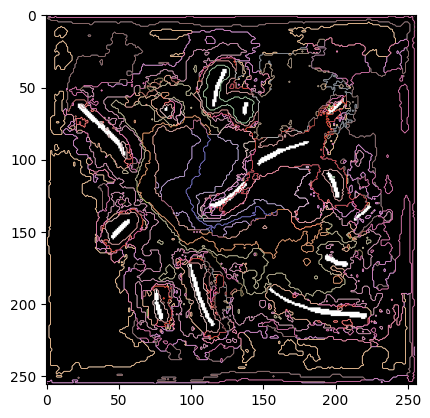

In [160]:
# display instance labels
plt.imshow(binary_mask.permute(1, 2, 0).squeeze(2), cmap="gray")

for i in range(num_instances):
    plt.contour(instance_labels == i, colors=[plt.cm.tab20(i)], linewidths=0.5)

Unique values in prediction: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')
Unique values in prediction: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')
Unique values in prediction: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       device='cuda:0')


(-0.5, 255.5, 255.5, -0.5)

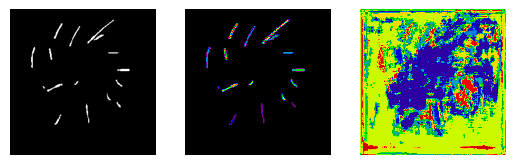

In [93]:
# plot the results of the multi-class segmentation
model.eval()
for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    # unique values in the prediction
    print(f"Unique values in prediction: {torch.unique(pred.argmax(dim=1))}")

# Plot the image
plt.subplot(1, 3, 1)
plt.imshow(X[0].cpu().permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")

# Plot the ground truth
plt.subplot(1, 3, 2)
plt.imshow(y[0].cpu().permute(1, 2, 0).squeeze(), cmap="nipy_spectral")
plt.axis("off")

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(pred[0].cpu().argmax(dim=0).detach().numpy(), cmap="nipy_spectral")
plt.axis("off")

Unique values in prediction: tensor([0, 2, 8], device='cuda:0')


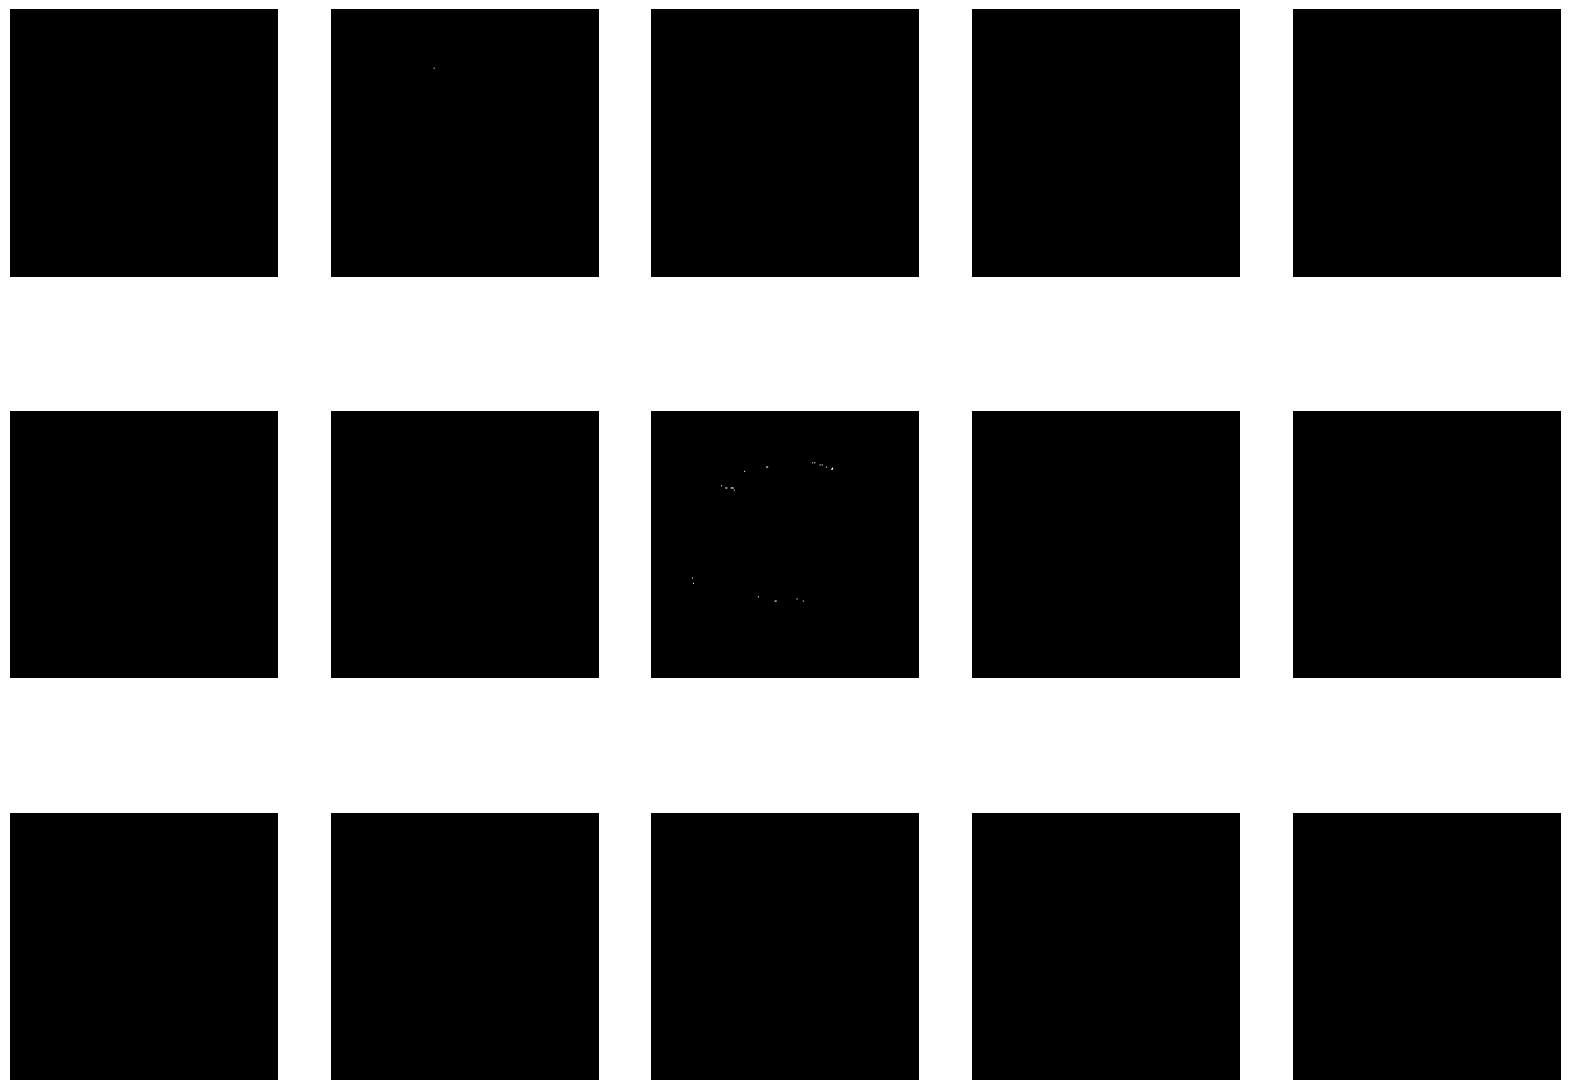

In [29]:
# forwards pass
model.eval()
with torch.no_grad():
    pred = model(binary_mask.unsqueeze(0).to(device))
    print(f"Unique values in prediction: {torch.unique(pred.argmax(dim=1))}")

# plot each instance in the prediction
plt.figure(figsize=(20, 20))
for i in range(1, 16):
    plt.subplot(4, 5, i)
    plt.imshow(pred[0].cpu().argmax(dim=0).detach().numpy() == i, cmap="gray")
    plt.axis("off")